In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

from models.cnmp import CNMP
from data.data_generators import *

import torch

torch.set_float32_matmul_precision('high')

def get_free_gpu():
    gpu_util = []
    for i in range(torch.cuda.device_count()):
        torch.cuda.set_device(i)  # Switch GPU
#        gpu_util.append((i, torch.cuda.memory_stats()['reserved_bytes.all.current'] / (1024 ** 2)))
        gpu_util.append((i, torch.cuda.utilization()))
    gpu_util.sort(key=lambda x: x[1])
    return gpu_util[0][0]

if torch.cuda.is_available():
    available_gpu = get_free_gpu()
    if available_gpu == 0:
        device = torch.device("cuda:0")
    else:
        device = torch.device(f"cuda:{available_gpu}")
else:
    device = torch.device("cpu")

print("Device :", device)

Device : cuda:0


torch.Size([32, 200, 1]) torch.Size([32, 200, 1]) cuda:0
torch.Size([8, 200, 1]) torch.Size([8, 200, 1])


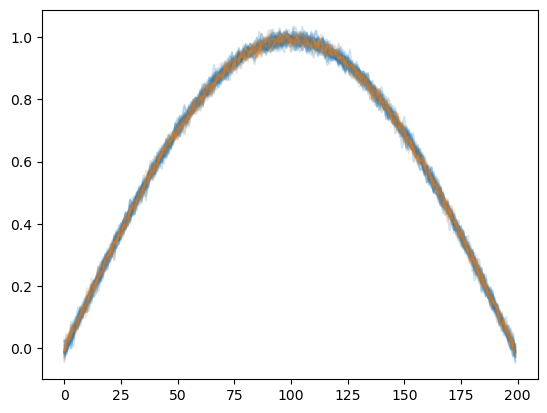

In [2]:
# Data generation

dx, dy = 1, 1
t_steps = 200
num_train_per_class, num_val_per_class = 32, 8
num_demos, num_val = 32, 8
num_classes = 1
n_max, m_max = 10, 10

x = torch.linspace(0, 1, t_steps).view(-1, 1)

generator_functions = [generate_sin]
y = []
for i in range(num_train_per_class + num_val_per_class):
    noise = (torch.randn((t_steps, 1))-0.5)*0.015
    y.append(generator_functions[0](x)+noise)

colors = [sns.color_palette('tab10')[0], sns.color_palette('tab10')[1], sns.color_palette('tab10')[2], sns.color_palette('tab10')[3]]
sns.set_palette('tab10')

for i, y_i in enumerate(y):
    if i < num_train_per_class:
        plt.plot(y_i, alpha=0.2, c=colors[0])
    else:
        plt.plot(y_i, alpha=0.2, c=colors[1])

x = x.unsqueeze(0).repeat(len(y), 1, 1).to(device)
y = torch.stack(y, dim=0).to(device)

vx, vy = x[num_train_per_class*num_classes:], y[num_train_per_class*num_classes:]
x, y = x[:num_train_per_class*num_classes], y[:num_train_per_class*num_classes]

print(x.shape, y.shape, x.device)
print(vx.shape, vy.shape)

In [3]:
batch_size = 8

model = CNMP(encoder_hidden_dims=[64,64], decoder_hidden_dims=[64,64], batch_size=batch_size, device=device)
optimizer = torch.optim.Adam(lr=1e-4, params=model.parameters())

pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

8706


In [4]:
obs = torch.zeros((batch_size, n_max, dx+dy), dtype=torch.float32, device=device)
tar_x = torch.zeros((batch_size, m_max, dx), dtype=torch.float32, device=device)
tar_y = torch.zeros((batch_size, m_max, dy), dtype=torch.float32, device=device)
obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)
tar_mask = torch.zeros((batch_size, m_max), dtype=torch.bool, device=device)

def prepare_masked_batch(t: list, traj_ids: list):
    obs.fill_(0)
    tar_x.fill_(0)
    tar_y.fill_(0)
    obs_mask.fill_(False)
    tar_mask.fill_(False)

    for i, traj_id in enumerate(traj_ids):
        traj = t[traj_id]

        n = torch.randint(1, n_max, (1,)).item()
        m = torch.randint(1, m_max, (1,)).item()

        permuted_ids = torch.randperm(t_steps)
        n_ids = permuted_ids[:n]
        m_ids = permuted_ids[n:n+m]
        
        obs[i, :n, :dx] = traj[n_ids]
        obs[i, :n, dx:] = (n_ids/t_steps).unsqueeze(1)
        obs_mask[i, :n] = True
        
        tar_x[i, :m] = traj[m_ids]
        tar_y[i, :m] = (m_ids/t_steps).unsqueeze(1)
        tar_mask[i, :m] = True

val_obs = torch.zeros((batch_size, n_max, dx+dy), dtype=torch.float32, device=device)
val_tar_x = torch.zeros((batch_size, t_steps, dx), dtype=torch.float32, device=device)
val_tar_y = torch.zeros((batch_size, t_steps, dy), dtype=torch.float32, device=device)
val_obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)

def prepare_masked_val_batch(t: list, traj_ids: list):
    val_obs.fill_(0)
    val_tar_x.fill_(0)
    val_tar_y.fill_(0)
    val_obs_mask.fill_(False)

    for i, traj_id in enumerate(traj_ids):
        traj = t[traj_id]

        n = torch.randint(1, n_max, (1,)).item()

        permuted_ids = torch.randperm(t_steps)
        n_ids = permuted_ids[:n]
        m_ids = torch.arange(t_steps)
        
        val_obs[i, :n, :dx] = traj[n_ids]
        val_obs[i, :n, dx:] = (n_ids/t_steps).unsqueeze(1)
        val_obs_mask[i, :n] = True
        
        val_tar_x[i] = traj[m_ids]
        val_tar_y[i] = (m_ids/t_steps).unsqueeze(1)

In [5]:
import time
import os

timestamp = int(time.time())
root_folder = f'outputs/tests/cnmp_basic/uni_sine/{str(timestamp)}/'

if not os.path.exists(root_folder):
    os.makedirs(root_folder)

if not os.path.exists(f'{root_folder}saved_models/'):
    os.makedirs(f'{root_folder}saved_models/')

if not os.path.exists(f'{root_folder}img/'):
    os.makedirs(f'{root_folder}img/')

torch.save(y, f'{root_folder}y.pt')


epochs = 500_000
epoch_iter = num_demos//batch_size  # number of batches per epoch (e.g. 100//32 = 3)
v_epoch_iter = num_val//batch_size  # number of batches per validation (e.g. 100//32 = 3)
avg_loss = 0

val_per_epoch = 1000
min_vl = 1000000

mse_loss = torch.nn.MSELoss()

tl = []
ve = []

cnmp_tl_path = f'{root_folder}cnmp_training_loss.pt'
cnmp_ve_path = f'{root_folder}cnmp_validation_error.pt'

for epoch in range(epochs):
    epoch_loss = 0

    traj_ids = torch.randperm(x.shape[0])[:batch_size*epoch_iter].chunk(epoch_iter)  # [:batch_size*epoch_iter] because nof_trajectories may be indivisible by batch_size

    for i in range(epoch_iter):
        prepare_masked_batch(x, traj_ids[i])

        optimizer.zero_grad()
        pred = model(obs, tar_x, obs_mask)
        loss = model.loss(pred, tar_y, tar_mask)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss = epoch_loss/epoch_iter
    tl.append(epoch_loss)

    if epoch % val_per_epoch == 0:
        with torch.no_grad():
            v_traj_ids = torch.randperm(vx.shape[0])[:batch_size*v_epoch_iter].chunk(v_epoch_iter)
            val_err = 0

            for j in range(v_epoch_iter):
                prepare_masked_val_batch(vx, v_traj_ids[j])

                p = model.val(val_obs, val_tar_x, val_obs_mask)
                vp_means = p[:, :, :dy]
                val_err += mse_loss(vp_means, val_tar_y).item()

            val_err = val_err/v_epoch_iter

            if val_err < min_vl:
                min_vl = val_err
                print(f'New best: {min_vl}')
                torch.save(model.state_dict(), f'{root_folder}saved_models/cnmp.pt')

            ve.append(val_err)

    avg_loss += epoch_loss

    if epoch % val_per_epoch == 0:
        print("Epoch: {}, CNMP Losses: {}".format(epoch, avg_loss/val_per_epoch))
        avg_loss = 0

torch.save(torch.Tensor(tl), cnmp_tl_path)
torch.save(torch.Tensor(ve), cnmp_ve_path)

New best: 0.13594388961791992
Epoch: 0, CNMP Losses: 0.0007603584975004196
New best: 1.7680454220680986e-06
Epoch: 1000, CNMP Losses: -3.3476185099387075
New best: 1.5091232796748955e-07
Epoch: 2000, CNMP Losses: -4.827983657218516
Epoch: 3000, CNMP Losses: -5.124947947952896
New best: 2.511561802975848e-08
Epoch: 4000, CNMP Losses: -5.255174568947405
Epoch: 5000, CNMP Losses: -5.269271998725832
Epoch: 6000, CNMP Losses: -5.27016359821707
Epoch: 7000, CNMP Losses: -5.506937211524695
Epoch: 8000, CNMP Losses: -5.487555700128898
New best: 1.67121338989773e-08
Epoch: 9000, CNMP Losses: -5.566774876767769
Epoch: 10000, CNMP Losses: -5.54510827652365
Epoch: 11000, CNMP Losses: -5.608870294798166
Epoch: 12000, CNMP Losses: -5.6588899150136855
Epoch: 13000, CNMP Losses: -5.706392304131761
New best: 9.019631264095551e-09
Epoch: 14000, CNMP Losses: -5.70954521086067
Epoch: 15000, CNMP Losses: -5.740798598971218
Epoch: 16000, CNMP Losses: -5.732462687995285
Epoch: 17000, CNMP Losses: -5.72420138

KeyboardInterrupt: 

In [ ]:
# from matplotlib.lines import Line2D

# def get_validation_batch(o_ids=[15]):
#     obs = torch.cat((vx[:, o_ids, :], vy[:, o_ids, :]), dim=-1)
#     tar = vx[:, torch.arange(t_steps)]
#     tar_val= vy[:, torch.arange(t_steps)]

#     return obs, tar, tar_val

# file_name = '1691573215'

# # Testing the best model
# model = CNP(input_dim=1, hidden_dim=204, output_dim=1, n_max_obs=6, n_max_tar=6, num_layers=3, batch_size=batch_size)
# model.load_state_dict(torch.load(f'saved_models/cnp_synth_{file_name}.pt'))
# model.eval()

# ids = [15]
# o, t, tr = get_validation_batch(ids)
# o, t, tr = o.cpu(), t.cpu(), tr.cpu()

# with torch.no_grad():
#     pred, _ = model(o, t)

# p = pred.cpu().numpy()
# t, tr = t.cpu().numpy(), tr.cpu().numpy()

# for i in range(vx.shape[0]):
#     plt.plot(range(t_steps), vy[i, :, 0].cpu(), 'k', alpha=0.15)

# for i in range(len(ids)):
#     plt.plot([ids[i]]*t_steps, torch.linspace(0, 1, t_steps), 'k--', alpha=0.75)

# for i in range(4):
#     plt.plot(range(t_steps), p[i, :, 0], 'b', alpha=0.6)

# line0 = Line2D([0], [0], label=f'ground truth', color='k', alpha=0.15)
# line1 = Line2D([0], [0], label=f'prediction', color='b', alpha=0.6)
# line2 = Line2D([0], [0], label=f'observation', color='k', linestyle='--', alpha=0.75)

# handles = [line0, line1, line2]

# plt.legend(handles=handles, loc='best')
# plt.title(f'CNP (Easy)')


In [ ]:
# ids = [60]
# o, t, tr = get_validation_batch(ids)
# o, t, tr = o.cpu(), t.cpu(), tr.cpu()

# with torch.no_grad():
#     pred, _ = model(o, t)

# p = pred.cpu().numpy()
# t, tr = t.cpu().numpy(), tr.cpu().numpy()

# for i in range(vx.shape[0]):
#     plt.plot(range(t_steps), vy[i, :, 0].cpu(), 'k', alpha=0.15)

# for i in range(len(ids)):
#     plt.plot([ids[i]]*t_steps, torch.linspace(0, 1, t_steps), 'k--', alpha=0.75)

# for i in range(4):
#     plt.plot(range(t_steps), p[i, :, 0], 'b', alpha=0.6)

# line0 = Line2D([0], [0], label=f'ground truth', color='k', alpha=0.15)
# line1 = Line2D([0], [0], label=f'prediction', color='b', alpha=0.6)
# line2 = Line2D([0], [0], label=f'observation', color='k', linestyle='--', alpha=0.75)

# handles = [line0, line1, line2]

# plt.legend(handles=handles, loc='best')
# plt.title(f'CNP (Difficult)')